In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

LABEL_MAP = {"Airplane": 0, "Bicycle": 1, "Butterfly": 2, "Car": 3, "Flower": 4, "House": 5, "Ladybug": 6, "Train": 7, "Tree": 8, "Whale": 9}
REVERSE_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

Using cuda


In [2]:
# Download all data from S3 bucket
# !aws s3 sync s3://ai-pictionary-data C:\Users\nickj\Documents\Duke\Masters\AIPI540\ai-pictionary\data

In [3]:
class CustomImageFolderDataset(Dataset):
    def __init__(self, image_paths, extra_transforms=True):
        """
        Custom dataset for loading images from a folder structure.
        Applies a base transform for train, val, and test sets.
        Applies extra transforms for training/val when specified.
        """
        self.base_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
                            ])
        self.images = image_paths
        self.extra_transforms = extra_transforms
        self.label_map = {"Airplane": 0, "Bicycle": 1, "Butterfly": 2, "Car": 3, "Flower": 4, "House": 5, "Ladybug": 6, "Train": 7, "Tree": 8, "Whale": 9}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        
        images = []
        # Apply base transform
        images.append(self.base_transform(image))
        # Horizontal flip
        if self.extra_transforms:
            images.append(self.base_transform(transforms.functional.hflip(image)))
        # Random rotation
        if self.extra_transforms:
            rotation_transform = transforms.RandomRotation((-30,30), fill=(255, 255, 255))
            images.append(self.base_transform(rotation_transform(image)))
        # Random Translation
        if self.extra_transforms:
            translation_transform = transforms.RandomAffine(0, translate=(0.2, 0.2), scale=(0.6, 1.4), fill=(255, 255, 255))
            images.append(self.base_transform(translation_transform(image)))
        
        # Assuming the folder names represent the labels, extract label from the file path
        label = img_path.split(os.sep)[-2]
        label = self.label_map[label]
        
        return images, label

In [4]:
def custom_collate_fn(batch):
    """
    Custom collate function to combine multiple images into a single batch tensor.
    
    Args:
    - batch: List of tuples (images, label), where 'images' is a list of 4 transformed images.
    
    Returns:
    - images_tensor: A tensor containing all images stacked together.
    - labels_tensor: A tensor containing all labels, repeated for each image transformation.
    """
    images_list = []
    labels_list = []
    for images, label in batch:
        # Stack all 4 images together, adding an extra dimension for 'stacking'
        images_stack = torch.stack(images, dim=0)
        images_list.append(images_stack)
        
        # Repeat the label 4 times to match the number of images
        labels_list.extend([label] * len(images))
    
    # Concatenate all images and labels from the batch together
    images_tensor = torch.cat(images_list, dim=0)
    labels_tensor = torch.tensor(labels_list)
    
    return images_tensor, labels_tensor

In [5]:
# Initialize your custom dataset
ROOT_DIR = 'C:\\Users\\nickj\\Documents\\Duke\\Masters\\AIPI540\\ai-pictionary\\data'
all_image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(ROOT_DIR) for f in filenames if os.path.splitext(f)[1].lower() in ['.png', '.jpg', '.jpeg']]
custom_dataset = CustomImageFolderDataset(all_image_paths, extra_transforms=True)

# Create a DataLoader
example_loader = DataLoader(custom_dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=custom_collate_fn)

Image 1 Label: Car
Image 2 Label: Flower


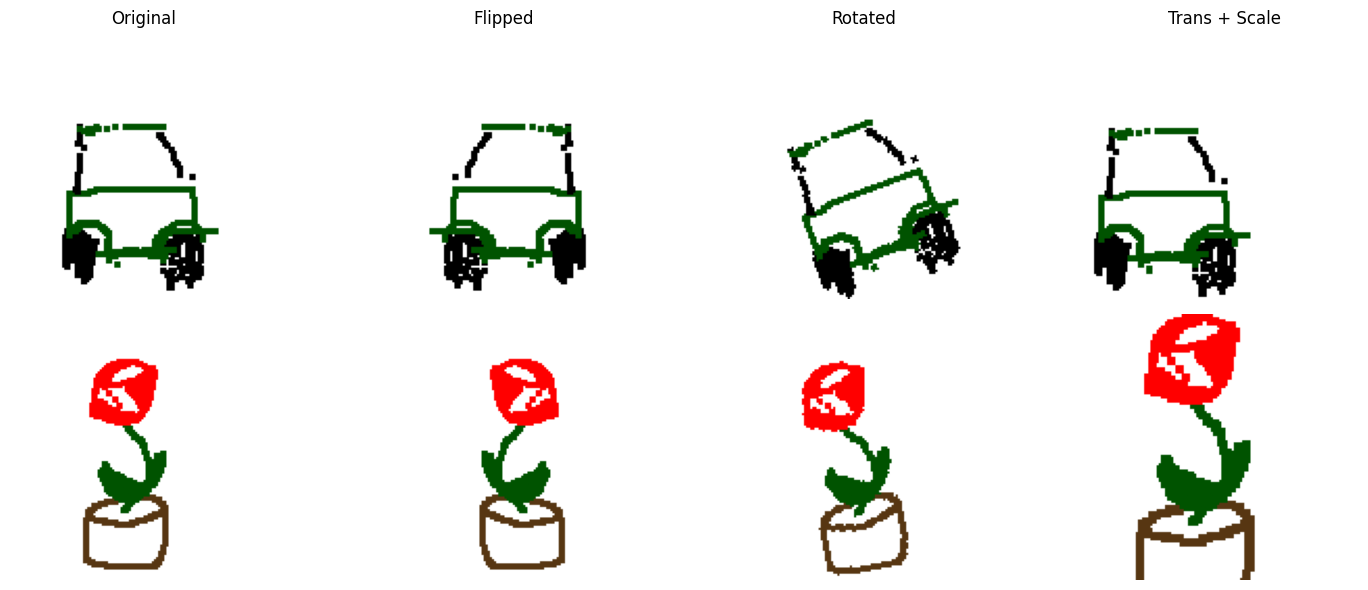

In [6]:
for images, labels in example_loader:
    transformations = 4  # Original, Flipped, Rotated, Translation + Scaling
    
    # Unnormalize the images for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    images_unnorm = images * std + mean
    images_unnorm = images_unnorm.clip(0, 1) 
    
    # Determine the number of rows needed for subplot (assuming 4 transformations per image)
    num_rows = len(images) // transformations
    plt.figure(figsize=(15, num_rows * 3)) 
    
    # Display images
    for i in range(len(images)):
        plt.subplot(num_rows, transformations, i + 1)
        img_np = images_unnorm[i].permute(1, 2, 0).numpy()  
        plt.imshow(img_np)
        plt.axis('off')
        
        # Add titles to the first row of images to denote the transformation
        if i < transformations:
            titles = ['Original', 'Flipped', 'Rotated', 'Trans + Scale']
            plt.title(titles[i % transformations])
    
    # Print labels for the entire batch; adjust printing if necessary for your label format
    # This assumes labels are repeated for each transformation of the same image
    unique_labels = labels[::transformations] 
    for idx, label in enumerate(unique_labels):
        print(f"Image {idx+1} Label: {REVERSE_LABEL_MAP[label.item()]}")
    
    plt.tight_layout()
    plt.show()
    break

## Transfer Learning with ResNet50 for Image Classification

In [7]:
# Load in pre-trained model
model = models.resnet50(weights="DEFAULT")
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Add on custom classifier
from collections import OrderedDict
classifier = torch.nn.Sequential(OrderedDict([
    ('fc1', torch.nn.Linear(2048, 512)),
    ('relu', torch.nn.ReLU()),
    ('fc2', torch.nn.Linear(512, 10)),
    ('output', torch.nn.Softmax(dim=1))
]))

model.fc = classifier
model = model.to(device)

In [8]:
# Setup training loop

def train(model, criterion, optimizer, train_loader, val_loader, epochs=10, device='cpu', best_model_path="../../saved_models/best_model.pth"):
    best_model = model.state_dict()
    best_val_loss = np.inf
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch {epoch+1} Training Loss: {train_loss}")

        # Validation
        model.eval()
        val_loss = 0
        accuracy = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                val_loss += loss.item()

                ps = torch.exp(output)
                _, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        val_loss = val_loss / len(val_loader)
        accuracy = accuracy / len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1} Validation Loss: {val_loss} Accuracy: {accuracy}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            print("Saving new best model...")
            torch.save(best_model, best_model_path)
    
    # Plot the training and validation losses
    plt.plot(train_losses, label="Training Loss", color="blue")
    plt.plot(val_losses, label="Validation Loss", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


Epoch 1 Training Loss: 2.06189276532429
Epoch 1 Validation Loss: 1.847766342228406 Accuracy: 0.6301369863013698
Saving new best model...
Epoch 2 Training Loss: 1.8757578541592854
Epoch 2 Validation Loss: 1.8175914336557257 Accuracy: 0.6506849315068494
Saving new best model...
Epoch 3 Training Loss: 1.8241040663021366
Epoch 3 Validation Loss: 1.8255595017785895 Accuracy: 0.6301369863013698
Epoch 4 Training Loss: 1.80111914727746
Epoch 4 Validation Loss: 1.8449844938434967 Accuracy: 0.613013698630137
Epoch 5 Training Loss: 1.7489222549810641
Epoch 5 Validation Loss: 1.7086359605397263 Accuracy: 0.7636986301369864
Saving new best model...
Epoch 6 Training Loss: 1.7086397249524186
Epoch 6 Validation Loss: 1.6965221721832067 Accuracy: 0.773972602739726
Saving new best model...
Epoch 7 Training Loss: 1.6818995650221662
Epoch 7 Validation Loss: 1.674208296488409 Accuracy: 0.7842465753424658
Saving new best model...
Epoch 8 Training Loss: 1.6650310798389156
Epoch 8 Validation Loss: 1.679545507

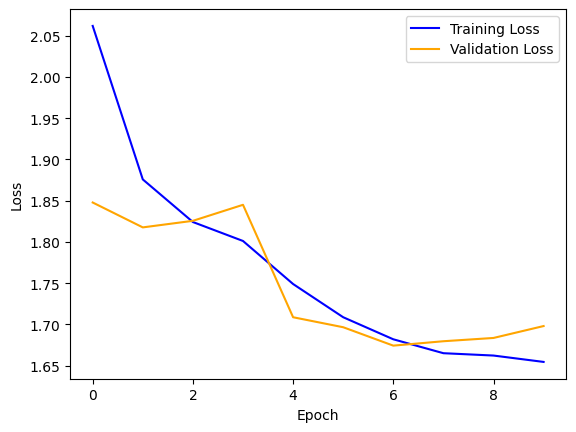

In [9]:
# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Define train, val, and test image paths. Then create a train and val datalaoders
all_image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(ROOT_DIR) for f in filenames if os.path.splitext(f)[1].lower() in ['.png', '.jpg', '.jpeg']]
train_image_paths, test_image_paths = train_test_split(all_image_paths, test_size=0.1)
train_image_paths, val_image_paths = train_test_split(train_image_paths, test_size=0.1)

train_dataset = CustomImageFolderDataset(train_image_paths, extra_transforms=True)
val_dataset = CustomImageFolderDataset(val_image_paths, extra_transforms=True)
test_dataset = CustomImageFolderDataset(test_image_paths, extra_transforms=False)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)

# Train the model
train(model, criterion, optimizer, train_loader, val_loader, epochs=10, device=device)



In [10]:
# Test the model
model.eval()
test_loss = 0
accuracy = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        test_loss += loss.item()

        ps = torch.exp(output)
        _, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

In [11]:
print(f"Test Loss: {test_loss / len(test_loader)} Accuracy: {accuracy / len(test_loader)}")

Test Loss: 1.661813457806905 Accuracy: 0.8024691358024691


In [39]:
# Test inference speed of the model on the CPU. Average over the entire test set.
import time
model = model.to('cpu')
model.eval()
start_time = time.time()
with torch.no_grad():
    for images, labels in test_loader:
        output = model(images)

end_time = time.time()
print(f"Average inference time per image: {(end_time - start_time) / len(test_loader)} seconds")

Average inference time per image: 0.07592075253710334 seconds


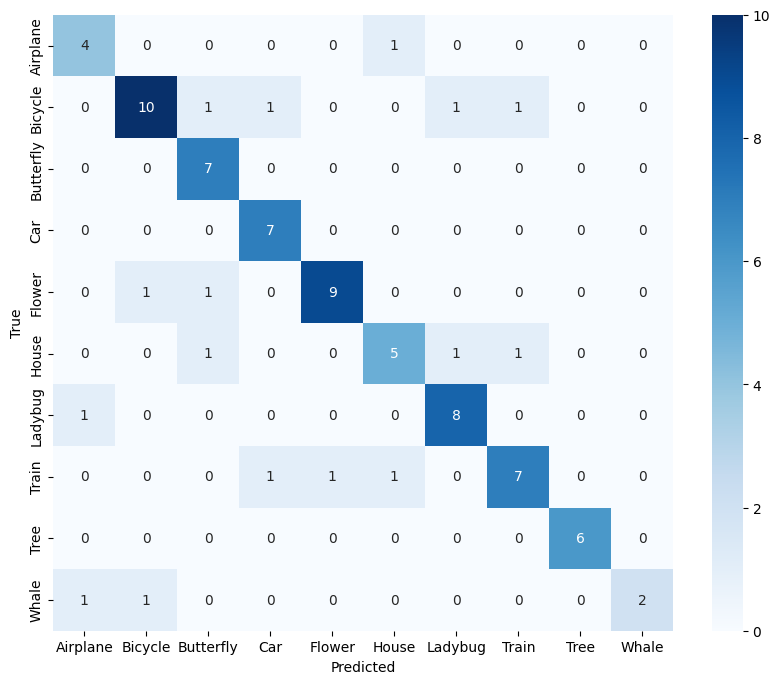

In [12]:
# Make a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        ps = torch.exp(output)
        _, top_class = ps.topk(1, dim=1)
        y_true.append(labels.item())
        y_pred.append(top_class.item())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

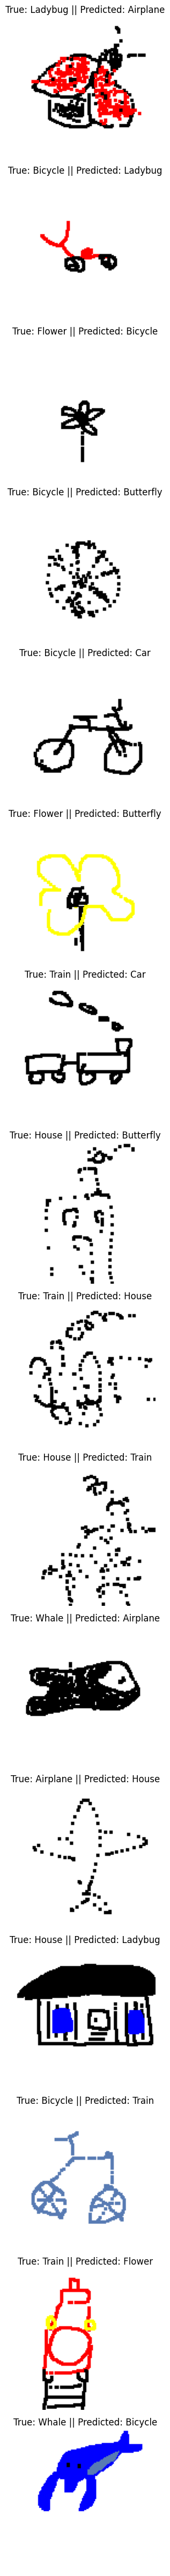

In [13]:
# Show the images that were misclassified
model.eval()
misclassified_images = []
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        ps = torch.exp(output)
        _, top_class = ps.topk(1, dim=1)
        if top_class != labels:
            misclassified_images.append(images)
            y_true.append(labels.item())
            y_pred.append(top_class.item())

# Display the misclassified images
num_rows = len(misclassified_images)
plt.figure(figsize=(15, num_rows * 3))
for i, image in enumerate(misclassified_images):
    plt.subplot(num_rows, 1, i + 1)
    img_np = image[0].permute(1, 2, 0).cpu().numpy()
    plt.imshow(img_np)
    plt.axis('off')
    plt.title(f"True: {REVERSE_LABEL_MAP[y_true[i]]} || Predicted: {REVERSE_LABEL_MAP[y_pred[i]]}")

plt.tight_layout()
plt.show()

In [24]:
# Save model
# torch.save(model.state_dict(), '../../saved_models/model_0.pth')

## Transfer Learning on ResNet18

In [21]:
# Load in pre-trained model
model_small = models.resnet18(weights="DEFAULT")
# Freeze parameters so we don't backprop through them
for param in model_small.parameters():
    param.requires_grad = False

# Add on custom classifier
classifier = torch.nn.Sequential(OrderedDict([
    ('fc1', torch.nn.Linear(512, 256)),
    ('relu', torch.nn.ReLU()),
    ('fc2', torch.nn.Linear(256, 10)),
    ('output', torch.nn.Softmax(dim=1))
]))

model_small.fc = classifier
model_small = model_small.to(device)

Starting training on cuda
Epoch 1 Training Loss: 2.148970060232209
Epoch 1 Validation Loss: 1.9580816340773073 Accuracy: 0.547945205479452
Saving new best model...
Epoch 2 Training Loss: 1.970633938545134
Epoch 2 Validation Loss: 1.9042135330095684 Accuracy: 0.571917808219178
Saving new best model...
Epoch 3 Training Loss: 1.8967556444610036
Epoch 3 Validation Loss: 1.8727656570199418 Accuracy: 0.5958904109589042
Saving new best model...
Epoch 4 Training Loss: 1.8498647474661105
Epoch 4 Validation Loss: 1.7428027571064153 Accuracy: 0.7226027397260274
Saving new best model...
Epoch 5 Training Loss: 1.82444234882913
Epoch 5 Validation Loss: 1.7199483489337033 Accuracy: 0.7534246575342466
Saving new best model...
Epoch 6 Training Loss: 1.7579101978278742
Epoch 6 Validation Loss: 1.6786054193157038 Accuracy: 0.7876712328767124
Saving new best model...
Epoch 7 Training Loss: 1.7274997205269047
Epoch 7 Validation Loss: 1.6603193185100817 Accuracy: 0.8116438356164384
Saving new best model...


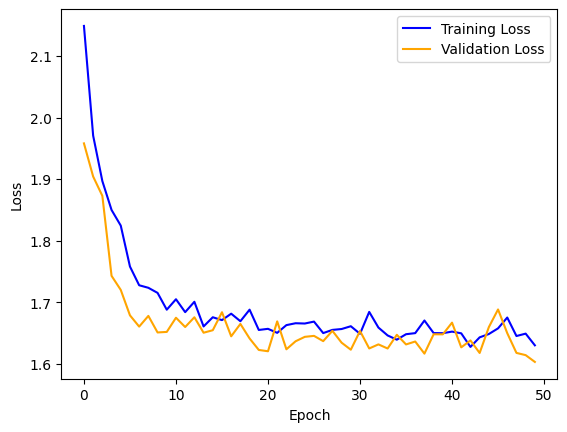

In [22]:
# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_small.fc.parameters(), lr=0.001, weight_decay=0.001)

# Train the model
print(f"Starting training on {device}")
train(model_small, criterion, optimizer, train_loader, val_loader, epochs=50, device=device)

In [23]:
# Test the model

# Load the best model
model_small.load_state_dict(torch.load("../../saved_models/best_model.pth"))
model_small.eval()
test_loss = 0
accuracy = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model_small(images)
        loss = criterion(output, labels)
        test_loss += loss.item()

        ps = torch.exp(output)
        _, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test Loss: {test_loss / len(test_loader)} Accuracy: {accuracy / len(test_loader)}")

Test Loss: 1.568121748206056 Accuracy: 0.9135802469135802


In [24]:
torch.save(model_small.state_dict(), '../../saved_models/TL_resnet18_new.pth')

In [40]:
# Test inference speed of the model on the CPU. Average over the entire test set.
model_small_speed_test = model_small.to('cpu')
model_small_speed_test.eval()
start_time = time.time()
with torch.no_grad():
    for images, labels in test_loader:
        output = model_small_speed_test(images)

end_time = time.time()
print(f"Average inference time per image: {(end_time - start_time) / len(test_loader)} seconds")

Average inference time per image: 0.020852012398802203 seconds


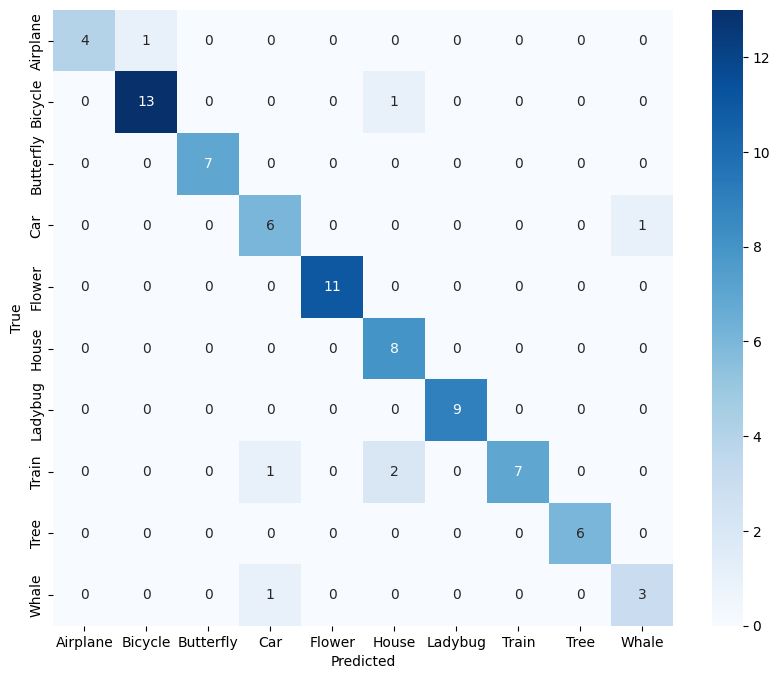

In [25]:
# Make a confusion matrix

model_small.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model_small(images)
        ps = torch.exp(output)
        _, top_class = ps.topk(1, dim=1)
        y_true.append(labels.item())
        y_pred.append(top_class.item())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


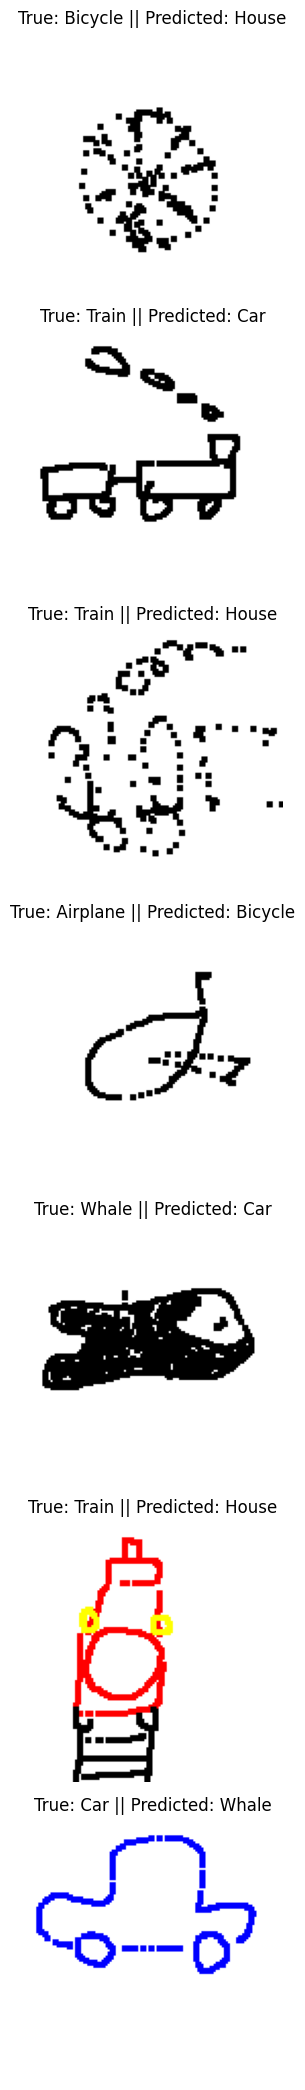

In [26]:
# Show the images that were misclassified
model_small.eval()
misclassified_images = []
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model_small(images)
        ps = torch.exp(output)
        _, top_class = ps.topk(1, dim=1)
        if top_class != labels:
            misclassified_images.append(images)
            y_true.append(labels.item())
            y_pred.append(top_class.item())

# Display the misclassified images
num_rows = len(misclassified_images)
plt.figure(figsize=(15, num_rows * 3))
for i, image in enumerate(misclassified_images):
    plt.subplot(num_rows, 1, i + 1)
    img_np = image[0].permute(1, 2, 0).cpu().numpy()
    plt.imshow(img_np)
    plt.axis('off')
    plt.title(f"True: {REVERSE_LABEL_MAP[y_true[i]]} || Predicted: {REVERSE_LABEL_MAP[y_pred[i]]}")

plt.tight_layout()
plt.show()

## Mean Model

In [45]:
# Look at the training data and find the most common color in each class
from collections import Counter

def get_dominant_color(image):
    """
    Get the dominant color in an image.
    
    Args:
    - image: A PIL Image object.
    
    Returns:
    - dominant_color: A tuple representing the RGB values of the dominant color.
    """
    # Get the RGB values of all pixels
    pixels = np.array(image)
    pixels = pixels.reshape(-1, 3)
    
    # Count the frequency of each color
    counter = Counter(map(tuple, pixels))
    
    # Get the second most common color (most common is the background)
    try:
        dominant_color = counter.most_common(2)[1][0]
    except IndexError:
        # If the image is blank
        dominant_color = counter.most_common(1)[0][0]
    
    return dominant_color

In [43]:
# Initialize a dictionary to store the dominant color for each class
dominant_colors = {}

# Load in the training data
train_dataset = CustomImageFolderDataset(train_image_paths, extra_transforms=False)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)

# Get the dominant color for each class
for images, labels in train_loader:
    for i in range(len(images)):
        image = images[i]
        label = labels[i].item()
        
        # Unnormalize the image
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        image_unnorm = image * std + mean
        image_unnorm = image_unnorm.clip(0, 1) 
        
        image_unnorm = transforms.ToPILImage()(image_unnorm[0])
        dominant_color = get_dominant_color(image_unnorm)
        if label not in dominant_colors:
            dominant_colors[label] = {dominant_color: 1}
        else:
            if dominant_color not in dominant_colors[label]:
                dominant_colors[label][dominant_color] = 1
            else:
                dominant_colors[label][dominant_color] += 1

# Get the most common color for each class
for label, colors in dominant_colors.items():
    most_common_color = max(colors, key=colors.get)
    dominant_colors[label] = most_common_color
print(dominant_colors)

{2: (131, 0, 131), 6: (255, 0, 0), 7: (0, 0, 0), 0: (0, 0, 0), 8: (0, 83, 0), 9: (0, 0, 255), 1: (0, 0, 0), 3: (0, 0, 0), 4: (255, 0, 0), 5: (0, 0, 0)}


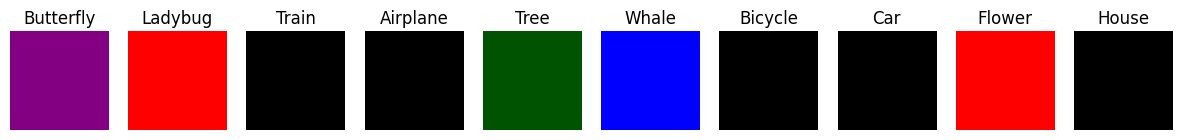

In [44]:
# Display the dominant color for each class
plt.figure(figsize=(15, 5))
c = 1
for label, color in dominant_colors.items():
    plt.subplot(1, 10, c)
    plt.imshow([[color]])
    plt.axis('off')
    plt.title(REVERSE_LABEL_MAP[label])
    c += 1

In [61]:
# Create a naive color-based classifier
def color_classifier(image):
    """
    Classify an image based on its dominant color.
    
    Args:
    - image: A PIL Image object.
    
    Returns:
    - label: The predicted label for the image.
    """
    # Most common colors found in the training data per class. This is effectively the naive 'model.'
    rgb_color_classes = {(131, 0, 131): [2], (255, 0, 0): [4, 6], (0, 0, 0): [0, 1, 3, 5, 7], (0, 83, 0): [8], (0, 0, 255): [9]}

    # Get the dominant color of the image
    dominant_rgb_color = get_dominant_color(image)
    
    # Find the closest dominant color in the dictionary
    min_distance = np.inf

    label = None
    for rgb_color, labels in rgb_color_classes.items():
        distance = np.linalg.norm(np.array(rgb_color) - np.array(dominant_rgb_color))
        if distance < min_distance:
            min_distance = distance
            label = labels

    if len(label) > 1:
        # If the dominant color belongs to multiple classes, choose randomly
        label = np.random.choice(label)
    else:
        label = label[0]
    
    return label

Naive Color-based Classifier Accuracy: 0.2839506172839506


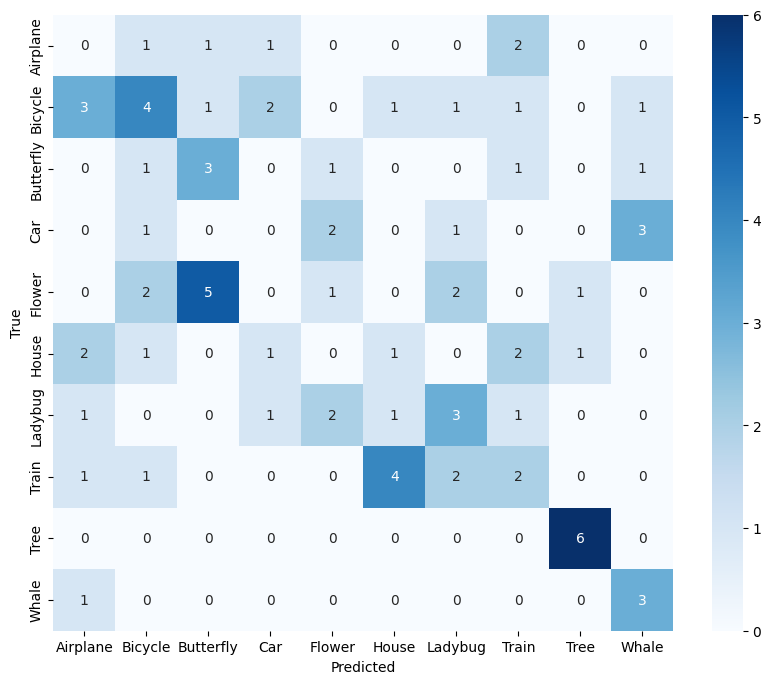

In [62]:
# Test the naive color-based classifier

test_dataset = CustomImageFolderDataset(test_image_paths, extra_transforms=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)

def unnormalize_image(image):
    """
    Unnormalize an image tensor and convert to pil image
    
    Args:
    - image: A tensor of shape (C, H, W).
    
    Returns:
    - image_unnorm: A PIL Image object, unormalized.
    """
    pil_transform = transforms.ToPILImage()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image_unnorm = image * std + mean
    image_unnorm = image_unnorm.clip(0, 1)
    image_unnorm = pil_transform(image_unnorm)
    return image_unnorm


predictions = []
y_true = []
for image, label in test_loader:
    image = image[0].cpu()
    label = label.item()
    y_true.append(label)
    pil_image = unnormalize_image(image)
    prediction = color_classifier(pil_image)
    predictions.append(prediction)

# Calculate accuracy
accuracy = np.mean(np.array(predictions) == np.array(y_true))
print(f"Naive Color-based Classifier Accuracy: {accuracy}")

# Make a confusion matrix
cm = confusion_matrix(y_true, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [67]:
# Calculate the precision and recall for each class
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, predictions, average=None)
recall = recall_score(y_true, predictions, average=None)

for i in range(10):
    print(f"{REVERSE_LABEL_MAP[i]} Precision: {round(precision[i],3)} Recall: {round(recall[i],3)}")

Airplane Precision: 0.0 Recall: 0.0
Bicycle Precision: 0.364 Recall: 0.286
Butterfly Precision: 0.3 Recall: 0.429
Car Precision: 0.0 Recall: 0.0
Flower Precision: 0.167 Recall: 0.091
House Precision: 0.143 Recall: 0.125
Ladybug Precision: 0.333 Recall: 0.333
Train Precision: 0.222 Recall: 0.2
Tree Precision: 0.75 Recall: 1.0
Whale Precision: 0.375 Recall: 0.75


## Train ResNet18 from Scratch

In [60]:
# Use resnet18 arch
model_scratch = models.resnet18(weights=None)
# Add on custom classifier
classifier = torch.nn.Sequential(OrderedDict([
    ('fc1', torch.nn.Linear(512, 256)),
    ('relu', torch.nn.ReLU()),
    ('fc2', torch.nn.Linear(256, 10)),
    ('output', torch.nn.LogSoftmax(dim=1))
]))

model_scratch.fc = classifier
model_scratch = model_scratch.to(device)

Starting training on cuda
Epoch 1 Training Loss: 2.5740034318551785
Epoch 1 Validation Loss: 2.3244712091472053 Accuracy: 0.0547945205479452
Saving new best model...
Epoch 2 Training Loss: 2.3189929520211567
Epoch 2 Validation Loss: 2.337013409562307 Accuracy: 0.1095890410958904
Epoch 3 Training Loss: 2.317575280259295
Epoch 3 Validation Loss: 2.3045447819853484 Accuracy: 0.1095890410958904
Saving new best model...
Epoch 4 Training Loss: 2.3047188723959575
Epoch 4 Validation Loss: 2.306976272635264 Accuracy: 0.1095890410958904
Epoch 5 Training Loss: 2.3048796770049305
Epoch 5 Validation Loss: 2.308454480889725 Accuracy: 0.1095890410958904
Epoch 6 Training Loss: 2.316891396917948
Epoch 6 Validation Loss: 2.31034002238757 Accuracy: 0.1095890410958904
Epoch 7 Training Loss: 2.313227589537458
Epoch 7 Validation Loss: 2.335540660440105 Accuracy: 0.11643835616438356
Epoch 8 Training Loss: 2.3248702025995023
Epoch 8 Validation Loss: 2.309748169494002 Accuracy: 0.1095890410958904
Epoch 9 Train

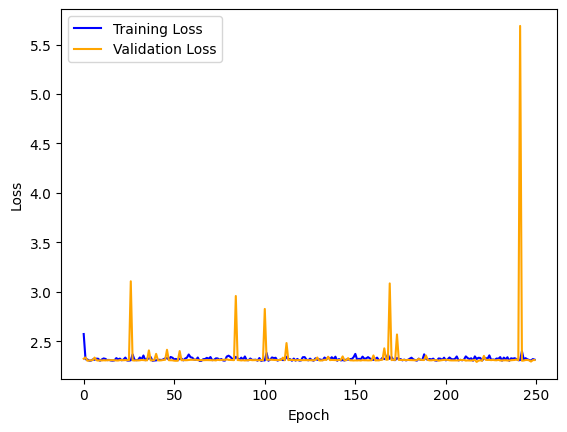

In [61]:
# Define loss and optimizer
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model_scratch.fc.parameters(), lr=0.008, weight_decay=0.001)

# Train the model
print(f"Starting training on {device}")
train(model_scratch, criterion, optimizer, train_loader, val_loader, epochs=250, device=device)